In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from scipy.stats import binned_statistic 

from sklearn.linear_model import LogisticRegression as lr
from sklearn.metrics import auc
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline

import statsmodels.api as sm 
from statsmodels.base.model import GenericLikelihoodModel 

In [117]:
test = pd.read_csv(r'../data/test.csv')
safe = pd.read_csv(r'../data/safe.csv')
unsafe = pd.read_csv(r'../data/unsafe.csv')
test.shape, safe.shape, unsafe.shape

((50, 2), (100, 2), (200, 2))

In [118]:
# safe.head()
test.head()

,class,X
0,0,1.649240
1,0,1.475661
2,0,1.279821
3,0,0.604183
4,0,1.350892


In [119]:
# test['class'].value_counts()

In [120]:
safe.describe()
# round(safe.max(),4)

,class,X
count,100.0,100.000000
mean,1.0,1.873446
std,0.0,0.275332
min,1.0,1.425014
25%,1.0,1.624757
50%,1.0,1.884341
75%,1.0,2.080559
max,1.0,2.361635


In [121]:
unsafe.describe()
# round(unsafe.max(),4)

,class,X
count,200.0,200.000000
mean,0.0,0.910473
std,0.0,0.428579
min,0.0,0.213738
25%,0.0,0.576824
50%,0.0,0.842651
75%,0.0,1.280218
max,0.0,1.695907


# Question 4 (2 points)
The third distribution you will need is the feature distribution. This is the concatenation of data
from “safe.csv” and “unsafe.csv”. Plot this distribution as bins of equal width. Note: this is a
probability distribution and not a simple histogram so make sure you normalize the distribution such that SEE EQUATION IN PDF

In [122]:
df = pd.concat([safe, unsafe], axis=0)  ## stack the 2 dfs on top of each other to combine into 1
df.shape

(300, 2)

In [123]:
# scaler = make_pipeline(MinMaxScaler())
# df_norm = scaler.fit_transform(df_concat) ## arr of normalized data

In [124]:
df

,class,X
0,1,1.983618
1,1,1.972120
2,1,1.993556
3,1,1.628395
4,1,1.965425
...,...,...
195,0,0.597829
196,0,0.775236
197,0,1.312605
198,0,1.277493


Syntax for
## scipy.stats.binned_statistic(x, values, statistic, bins, range)

* x = A sequence of values to be binned (divided into sections)
* values (y values) = The data on which the statistic will be computed. This must be the same shape as x, or a set of sequences - each the same shape as x. If values is a set of sequences, the statistic will be computed on each independently.
* statistic = mean, count, etc
* bins = If bins is an int, it defines the number of equal-width bins in the given range (10 by default). If bins is a sequence, it defines the bin edges, including the rightmost edge, allowing for non-uniform bin widths.

PICTURE "x" as array of x values, "values" as array of Y values. Then each corresponding pair of elemnts are like two lists of x,y coords with one list of the x's and one list of the y's

In [125]:
# # Example
# x = [1, 1, 2, 5, 7]
# y = [1.0, 1.0, 2.0, 1.5, 3.0]
# binned_statistic(x, y, 'sum', bins=2)

### Results:

statistic: The values of the selected statistic in each bin.

bin_edges: Return the bin edges (length(statistic)+1).

bin_number: Indices of the bins (corresponding to bin_edges) in which each value of x belongs. Same length as values. A binnumber of i means the corresponding value is between (bin_edges[i-1], bin_edges[i]).

In [126]:
df.shape

(300, 2)

In [127]:
x = df["X"]
values = df["class"]
n = 10
total_obs = df.shape[0]
bin_counts, bin_edges, binnumber = binned_statistic(x=x, values=values, statistic='count', bins=n)
bin_width = (bin_edges[1] - bin_edges[0])  ## width is same for all bins
print(round(bin_width,4))
print([int(b) for b in bin_counts])

0.2148
[34, 29, 38, 25, 25, 35, 48, 25, 24, 17]


In [128]:
# bin_probs = [bc / total_obs for bc in bin_counts]
# sum(bin_probs) ## sums to 1
# print(bin_probs)

In [129]:
# np_bin_densities, edges = np.histogram(x, bins=bin_edges, density=True)


# calculate density of each bin manuualy according to formula
## gives same values as np density formula above
bin_densities = [bin_counts[b] / (total_obs * bin_width) for b in range(n)]
print([round(b,4) for b in bin_densities])

[0.5276, 0.4501, 0.5897, 0.388, 0.388, 0.5432, 0.7449, 0.388, 0.3725, 0.2638]


In [130]:
for b in bin_edges:
    print(b)

0.2137377198274994
0.42852744891639694
0.6433171780052944
0.858106907094192
1.0728966361830896
1.2876863652719872
1.5024760943608846
1.7172658234497822
1.9320555525386798
2.146845281627577
2.361635010716475


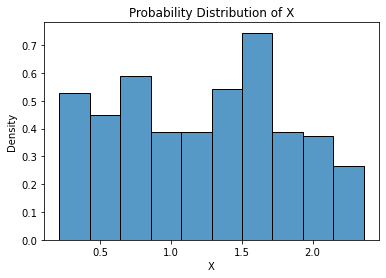

In [131]:
## imitate this, using displot instead
sns.histplot(x, stat='density', bins=10)
plt.title('Probability Distribution of X')
plt.savefig('quiz3_density_plot.png')

In [132]:
# ## generates similar img to above cell
# sns.distplot(x, norm_hist=True, kde=False, bins=10, hist_kws=dict(edgecolor="k", linewidth=2))

In [133]:
bins = sorted(bin_densities)

In [134]:
bins

[0.26382391237717595,
 0.3724572880618955,
 0.3879763417311411,
 0.3879763417311411,
 0.3879763417311411,
 0.4500525564081237,
 0.5276478247543519,
 0.5431668784235976,
 0.5897240394313344,
 0.744914576123791]

## Question 5 (2 points)
You now have all the components to compute the Bayesian posterior. Assume a client’s feature,
X = 1.0. What is the posterior probability the client is in the “safe” and “unsafe” class?


---

How to do this

1. Compute P(safe|X) and P(unsafe|X)
    - Need to find P(X|safe), P(X|unsafe), P(safe), P(unsafe), P(X)

In [59]:
p_safe = safe.shape[0] / df.shape[0]
p_unsafe = unsafe.shape[0] / df.shape[0]

# Q6

In [136]:
## shuffle rows to prevent learning patterns that doesn't exist
df2 = df.sample(frac=1).reset_index(drop=True)
df2

,class,X
0,0,1.146854
1,0,0.591543
2,0,1.310960
3,1,1.914846
4,1,2.139631
...,...,...
295,0,1.224641
296,1,2.036829
297,0,0.839955
298,1,1.477630


In [144]:
X = df2["X"].to_numpy().reshape(-1, 1)
y = df2["class"].to_numpy()

In [145]:
log_reg = lr(random_state=0).fit(X, y)

In [146]:
log_reg.predict(X)

array([0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0,
       1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1], d

In [148]:
log_reg.score(X,y)

0.8966666666666666

In [149]:
log_reg.coef_

array([[5.25161665]])